In [1]:
from collections import defaultdict

import itertools

import tensorflow as tf
import tensorflow_text as tf_text
import numpy as np
import matplotlib.pyplot as plt

import download_dataset
import ocr_input

plt.rcParams['figure.figsize'] = [15, 12]

tf.executing_eagerly() 

True

In [2]:
import download_dataset  # dowloading from google drive
import ocr_input         # deals with reading dataset and xml parsing


for elt in ["label", "image", "ocr", "dataset_assignment"]:
    download_dataset.download_and_extract(elt)

dataset_path = "dataset"

Unzipping ./tmp/image.zip to dataset/image…
Unzipping ./tmp/ocr.zip to dataset/ocr…


In [37]:
import string

import nltk

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

stop_words = stopwords.words('english')
stemmer = PorterStemmer()

def clean_text(text):
    text = text.lower()
    text = "".join([char for char in text if char not in string.punctuation])
    words = text.split()

    filtered_words = [word for word in words if word not in stop_words]
    stemmed = [stemmer.stem(word) for word in filtered_words]

    return " ".join(stemmed)


In [38]:
# Read train / test split and labels
raw_class_indices = ['1', '2', '3', '4', '11']
class_names = ['form', 'email', 'handwritten', 'advertisement', 'invoice']
NUM_CLASSES = len(class_names)

labels = {}
with open(os.path.join(dataset_path, "label.txt"), "r") as f:
    for line in f.readlines():
        file_id, lbl = line.strip().split(",")
        labels[file_id] = lbl

dataset = defaultdict(list)
with open(os.path.join(dataset_path, "dataset_assignment.txt"), "r") as f:
    for line in f.readlines():
        line = line.split('\n')[0]
        file_id, assignment = line.split(',')
        img_path = os.path.join(dataset_path, "image_png", f"{file_id}.png")
        ocr_path = os.path.join(dataset_path, "ocr", f"{file_id}.xml")
        
        text = ocr_input.parse_xml(ocr_path)
        text = clean_text(text) 
        
        dataset[f"{assignment}_img"].append(img_path)
        dataset[f"{assignment}_ocr"].append(text)
        dataset[f"{assignment}_lbl"].append(raw_class_indices.index(labels[file_id]))

In [4]:
PPI = 35  # Number of Pixels Per Inch 
IMG_WIDTH, IMG_HEIGHT = int(PPI * 8.5), int(PPI * 11)


@tf.function
def decode_img(img):
    # convert the compressed string to a uint8 tensor
    img = tf.io.decode_png(img, channels=1)
    # convert to floats in the [0,1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # resize the image to the desired size
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])
    return img

@tf.function
def process_image_path(file_path, lbl):
    file = tf.io.read_file(file_path)
    img = decode_img(file)
    return img, lbl

In [39]:
VOCAB_SIZE = 10_000

# tokenizer = tf_text.BertTokenizer("bert_en_uncased_L-12_H-768_A-12_4/assets/vocab.txt")
tokenizer = tf_text.WhitespaceTokenizer()

def process_text(text, lbl):
    tokens = tokenizer.tokenize(text)
    
    # return tokens.merge_dims(0, 2)[:500], lbl

    tokens = tf.strings.to_hash_bucket_fast(tokens, VOCAB_SIZE)
    return tokens[:400], lbl

In [ ]:
def process_mix(inputs, lbl):
    text, img_path = inputs
    img, _ = process_image_path(img_path, lbl)
    tokens, _ = process_text(text, lbl)
    return {"input_nlp": tokens, "input_cv": img}, lbl

In [5]:
train_img_ds = tf.data.Dataset.from_tensor_slices((dataset["training_img"], dataset["training_lbl"]))
train_img_ds = train_img_ds.shuffle(100000)
train_img_ds = train_img_ds.map(process_image_path)

test_img_ds = tf.data.Dataset.from_tensor_slices((dataset["test_img"], dataset["test_lbl"]))
test_img_ds = test_img_ds.map(process_image_path)


2021-10-20 10:55:29.840317: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 10:55:29.876538: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 10:55:29.877155: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-20 10:55:29.878319: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Instructions for updating:
`tf.batch_gather` is deprecated, please use `tf.gather` with `batch_dims=-1` instead.


In [40]:
train_txt_ds = tf.data.Dataset.from_tensor_slices((dataset["training_ocr"], dataset["training_lbl"]))
train_txt_ds = train_txt_ds.shuffle(100000)
train_txt_ds = train_txt_ds.map(process_text)

test_txt_ds = tf.data.Dataset.from_tensor_slices((dataset["test_ocr"], dataset["test_lbl"]))
test_txt_ds = test_txt_ds.map(process_text)

In [ ]:
train_mix_ds = tf.data.Dataset.from_tensor_slices(((dataset["training_ocr"], dataset["training_img"]), dataset["training_lbl"]))
train_mix_ds = train_mix_ds.shuffle(100000)
train_mix_ds = train_mix_ds.map(process_mix)

test_mix_ds = tf.data.Dataset.from_tensor_slices(((dataset["test_ocr"], dataset["test_img"]), dataset["test_lbl"]))
test_mix_ds = test_mix_ds.map(process_mix)

In [6]:
for (token, img), lbl in test_mix_ds.padded_batch(3).take(1):
    print(token, img, lbl)

2021-10-20 10:56:00.811566: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


input_nlp input_cv tf.Tensor([2 2 2], shape=(3,), dtype=int32)


In [6]:
def plot_multiple_docs(imgs, lbls, dims):
    m, n = dims
    assert m*n >= len(lbls)
    fig, axs = plt.subplots(n, m)
    if isinstance(axs[0], list):
        axs = list(itertools.chain(*axs))
    for ax, img, lbl in zip(axs, imgs, lbls):
        ax.imshow(img, cmap="gray")
        ax.set_title(class_names[lbl])
        ax.set_xticks([])
        ax.set_yticks([])



In [7]:
imgs = []
lbls = []
for img, lbl in list_train_img_ds.take(5):
    imgs.append(img.numpy())
    lbls.append(lbl.numpy())
print(imgs[0].shape)

2021-10-08 21:11:47.770889: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(385, 297, 1)


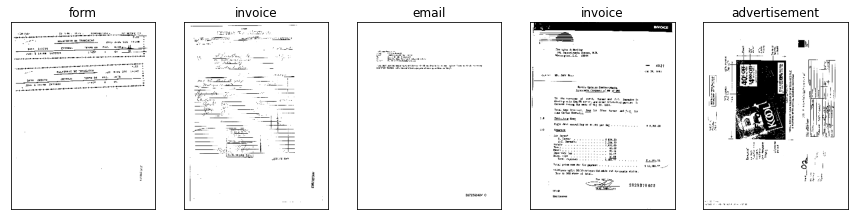

In [8]:
plot_multiple_docs(imgs, lbls, (5, 1))

## Computer Vision

In [24]:
cv_model = tf.keras.Sequential([
    tf.keras.Input(shape=(385, 297, 1)),
    tf.keras.layers.Conv2D(filters=8 , kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu),
    tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D(pool_size=(3, 3)),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2), activation=tf.nn.relu),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.nn.softmax)

])
cv_model.build()

In [25]:
cv_model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 383, 295, 8)       80        
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 191, 147, 16)      1168      
_________________________________________________________________
dropout_14 (Dropout)         (None, 191, 147, 16)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 187, 143, 32)      12832     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 62, 47, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 29, 22, 32)        25632     
_________________________________________________________________
dropout_15 (Dropout)         (None, 29, 22, 32)       

In [26]:
batch_size = 256
epochs = 10

cv_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

cv_hist = cv_model.fit(train_img_ds.batch(batch_size),
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_data=test_img_ds.batch(8),
                       callbacks=[tf.keras.callbacks.TensorBoard("log/cv")])


2021-10-20 11:05:24.362539: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 11:05:24.362585: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 11:05:24.363623: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 1 GPUs
2021-10-20 11:05:24.364320: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcupti.so.11.2'; dlerror: libcupti.so.11.2: cannot open shared object file: No such file or directory
2021-10-20 11:05:24.702499: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 11:05:24.702655: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/10
 1/51 [..............................] - ETA: 2:10 - loss: 1.6206 - accuracy: 0.1641

2021-10-20 11:05:27.516793: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 11:05:27.522147: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


 2/51 [>.............................] - ETA: 1:29 - loss: 1.7188 - accuracy: 0.1836

2021-10-20 11:05:29.236898: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 11:05:29.237652: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-10-20 11:05:29.540405: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 424 callback api events and 427 activity events. 
2021-10-20 11:05:29.598184: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 11:05:29.720694: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2021_10_20_11_05_29

2021-10-20 11:05:29.750534: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2021_10_20_11_05_29/doudou-blade.trace.json.gz
2021-10-20 11:05:29.949903: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plug

51/51 [==============================] - 98s 2s/step - loss: 1.1910 - accuracy: 0.5174 - val_loss: 0.9893 - val_accuracy: 0.6368
Epoch 2/10
51/51 [==============================] - 103s 2s/step - loss: 0.7857 - accuracy: 0.7174 - val_loss: 0.7202 - val_accuracy: 0.7556
Epoch 3/10
51/51 [==============================] - 91s 2s/step - loss: 0.6359 - accuracy: 0.7732 - val_loss: 0.6751 - val_accuracy: 0.7535
Epoch 4/10
51/51 [==============================] - 93s 2s/step - loss: 0.5217 - accuracy: 0.8155 - val_loss: 0.5379 - val_accuracy: 0.8146
Epoch 5/10
51/51 [==============================] - 88s 2s/step - loss: 0.4608 - accuracy: 0.8366 - val_loss: 0.4924 - val_accuracy: 0.8285
Epoch 6/10
51/51 [==============================] - 91s 2s/step - loss: 0.3902 - accuracy: 0.8627 - val_loss: 0.4873 - val_accuracy: 0.8282
Epoch 7/10
51/51 [==============================] - 91s 2s/step - loss: 0.3518 - accuracy: 0.8764 - val_loss: 0.4456 - val_accuracy: 0.8405
Epoch 8/10
51/51 [============

## Natural language Processing

In [41]:
nlp_model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,), dtype=tf.int64, ragged=True),
    tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=256),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256), merge_mode="sum"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(units=128, activation=tf.nn.relu),
    tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.nn.softmax)
])

nlp_model.build()

In [42]:
nlp_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         2560000   
_________________________________________________________________
dropout_18 (Dropout)         (None, None, 256)         0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               1050624   
_________________________________________________________________
dropout_19 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 128)               32896     
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 645       
Total params: 3,644,165
Trainable params: 3,644,165
Non-trainable params: 0
____________________________________________

In [43]:
batch_size = 128
epochs = 10

nlp_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

nlp_hist = nlp_model.fit(train_txt_ds.padded_batch(batch_size),
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_data=test_txt_ds.padded_batch(8),
                         callbacks=[tf.keras.callbacks.TensorBoard("logs/nlp")])


2021-10-20 11:36:30.282025: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 11:36:30.282050: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 11:36:30.420760: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 11:36:30.420863: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/10
  1/102 [..............................] - ETA: 3:29 - loss: 1.6117 - accuracy: 0.1875

2021-10-20 11:36:33.750330: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 11:36:33.750350: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/102 [..............................] - ETA: 50s - loss: 1.6092 - accuracy: 0.1992 

2021-10-20 11:36:34.258888: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 11:36:34.259398: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-10-20 11:36:34.294027: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 5111 callback api events and 5148 activity events. 
2021-10-20 11:36:34.343426: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 11:36:34.419382: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/nlp/train/plugins/profile/2021_10_20_11_36_34

2021-10-20 11:36:34.472858: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/nlp/train/plugins/profile/2021_10_20_11_36_34/doudou-blade.trace.json.gz
2021-10-20 11:36:34.530163: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/

102/102 [==============================] - 35s 326ms/step - loss: 0.9752 - accuracy: 0.5779 - val_loss: 0.6414 - val_accuracy: 0.7490
Epoch 2/10
102/102 [==============================] - 32s 315ms/step - loss: 0.4984 - accuracy: 0.8264 - val_loss: 0.6229 - val_accuracy: 0.7800
Epoch 3/10
102/102 [==============================] - 33s 320ms/step - loss: 0.3170 - accuracy: 0.8968 - val_loss: 0.5629 - val_accuracy: 0.8179
Epoch 4/10
102/102 [==============================] - 32s 316ms/step - loss: 0.1934 - accuracy: 0.9416 - val_loss: 0.6409 - val_accuracy: 0.7984
Epoch 5/10
102/102 [==============================] - 32s 317ms/step - loss: 0.1465 - accuracy: 0.9544 - val_loss: 0.7281 - val_accuracy: 0.8191
Epoch 6/10
102/102 [==============================] - 32s 318ms/step - loss: 0.0996 - accuracy: 0.9685 - val_loss: 0.8194 - val_accuracy: 0.8104
Epoch 7/10
102/102 [==============================] - 32s 317ms/step - loss: 0.0872 - accuracy: 0.9719 - val_loss: 0.8281 - val_accuracy: 0.8

## Mix CV & NLP

In [44]:
# NLP part
input_nlp = tf.keras.Input(shape=(None,), dtype=tf.int64, ragged=True, name="input_nlp")
nlp_x = tf.keras.layers.Embedding(input_dim=VOCAB_SIZE, output_dim=256)(input_nlp)
nlp_x = tf.keras.layers.Dropout(rate=0.5)(nlp_x)
nlp_x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units=256), merge_mode="sum")(nlp_x)
nlp_x = tf.keras.layers.Dropout(rate=0.5)(nlp_x)
nlp_x = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(nlp_x)
nlp_x = tf.keras.layers.BatchNormalization()(nlp_x)

# CV part
input_cv = tf.keras.Input(shape=(385, 297, 1), name="input_cv")
cv_x = tf.keras.layers.Conv2D(filters=8 , kernel_size=(3, 3), strides=(1, 1), activation=tf.nn.relu)(input_cv)
cv_x = tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), strides=(2, 2), activation=tf.nn.relu)(cv_x)
cv_x = tf.keras.layers.Dropout(rate=0.5)(cv_x)
cv_x = tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(1, 1), activation=tf.nn.relu)(cv_x)
cv_x = tf.keras.layers.MaxPooling2D(pool_size=(3, 3))(cv_x)
cv_x = tf.keras.layers.Conv2D(filters=32, kernel_size=(5, 5), strides=(2, 2), activation=tf.nn.relu)(cv_x)
cv_x = tf.keras.layers.Dropout(rate=0.5)(cv_x)
cv_x = tf.keras.layers.Flatten()(cv_x)
cv_x = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)(cv_x)
cv_x = tf.keras.layers.BatchNormalization()(cv_x)

merge_x = cv_x + nlp_x
out = tf.keras.layers.Dense(units=NUM_CLASSES, activation=tf.nn.softmax)(merge_x)

mix_model = tf.keras.Model(inputs=[input_nlp, input_cv], outputs=out)


In [45]:
mix_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cv (InputLayer)           [(None, 385, 297, 1) 0                                            
__________________________________________________________________________________________________
conv2d_28 (Conv2D)              (None, 383, 295, 8)  80          input_cv[0][0]                   
__________________________________________________________________________________________________
conv2d_29 (Conv2D)              (None, 191, 147, 16) 1168        conv2d_28[0][0]                  
__________________________________________________________________________________________________
dropout_22 (Dropout)            (None, 191, 147, 16) 0           conv2d_29[0][0]                  
______________________________________________________________________________________________

In [46]:
batch_size = 128
epochs = 10

mix_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

mix_hist = mix_model.fit(train_mix_ds.padded_batch(batch_size),
                         batch_size=batch_size,
                         epochs=epochs,
                         validation_data=test_mix_ds.padded_batch(8),
                         callbacks=[tf.keras.callbacks.TensorBoard("logs/mix")])


2021-10-20 11:42:25.390610: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 11:42:25.390633: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2021-10-20 11:42:25.530680: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 11:42:25.530910: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


Epoch 1/10


2021-10-20 11:42:31.438866: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.03GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-20 11:42:32.035804: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.28GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2021-10-20 11:42:32.429195: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.45GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


  1/102 [..............................] - ETA: 10:41 - loss: 2.2512 - accuracy: 0.2109

2021-10-20 11:42:33.370209: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2021-10-20 11:42:33.370236: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/102 [..............................] - ETA: 2:26 - loss: 2.1060 - accuracy: 0.2383 

2021-10-20 11:42:34.874908: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2021-10-20 11:42:34.875552: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2021-10-20 11:42:34.925498: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 5570 callback api events and 5611 activity events. 
2021-10-20 11:42:34.988834: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2021-10-20 11:42:35.086358: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/mix/train/plugins/profile/2021_10_20_11_42_34

2021-10-20 11:42:35.166458: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/mix/train/plugins/profile/2021_10_20_11_42_34/doudou-blade.trace.json.gz
2021-10-20 11:42:35.231875: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/

102/102 [==============================] - 150s 1s/step - loss: 0.9255 - accuracy: 0.6665 - val_loss: 5.4864 - val_accuracy: 0.2016
Epoch 2/10
102/102 [==============================] - ETA: 0s - loss: 0.3932 - accuracy: 0.8703